# COSC2789 Practical Data Science
# Assignment 2: Data Modeling
**Group 4**
- Name & ID here

**Goal**: To classify income range of survey respondents. 

**Performance measures** 
- Accuracy 
- Recall 
- F1 score 
- AUC ROC 

**Data description** 
*The dataset contains responses from the 2020 Stack Overflow Developer survey, which is among the largest and most comprehensive survey of software developers.*

## Task 1.1 Data Retrieving and Cleaning 

### Setting up

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#ignore unneccessary warning
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# Get the data
url = 'survey_results_public.csv'
survey = pd.read_csv(url, sep=',')

In [3]:
survey.head()

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,...,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat more welcome now than last year,NaN,7,4
2,3,I code primarily as a hobby,Yes,NaN,15,NaN,NaN,NaN,Russian Federation,NaN,...,Neither easy nor difficult,Appropriate in length,NaN,NaN,NaN,NaN,Somewhat more welcome now than last year,NaN,4,NaN
3,4,I am a developer by profession,Yes,25.0,18,NaN,NaN,NaN,Albania,Albanian lek,...,NaN,NaN,No,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat less welcome now than last year,40.0,7,4
4,5,"I used to be a developer by profession, but no...",Yes,31.0,16,NaN,NaN,NaN,United States,NaN,...,Easy,Too short,No,"Computer science, computer engineering, or sof...",Django;Ruby on Rails,Ruby on Rails,Just as welcome now as I felt last year,NaN,15,8


In [4]:
survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64461 entries, 0 to 64460
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Respondent                    64461 non-null  int64  
 1   MainBranch                    64162 non-null  object 
 2   Hobbyist                      64416 non-null  object 
 3   Age                           45446 non-null  float64
 4   Age1stCode                    57900 non-null  object 
 5   CompFreq                      40069 non-null  object 
 6   CompTotal                     34826 non-null  float64
 7   ConvertedComp                 34756 non-null  float64
 8   Country                       64072 non-null  object 
 9   CurrencyDesc                  45472 non-null  object 
 10  CurrencySymbol                45472 non-null  object 
 11  DatabaseDesireNextYear        44070 non-null  object 
 12  DatabaseWorkedWith            49537 non-null  object 
 13  D

In [5]:
# generate descriptive stats 
survey.describe()

,Respondent,Age,CompTotal,ConvertedComp,WorkWeekHrs
count,64461.000000,45446.000000,3.482600e+04,3.475600e+04,41151.000000
mean,32554.079738,30.834111,3.190464e+242,1.037561e+05,40.782174
std,18967.442360,9.585392,inf,2.268853e+05,17.816383
min,1.000000,1.000000,0.000000e+00,0.000000e+00,1.000000
25%,16116.000000,24.000000,2.000000e+04,2.464800e+04,40.000000
50%,32231.000000,29.000000,6.300000e+04,5.404900e+04,40.000000
75%,49142.000000,35.000000,1.250000e+05,9.500000e+04,44.000000
max,65639.000000,279.000000,1.111111e+247,2.000000e+06,475.000000


In [6]:
preprocess = survey.copy()

### Missing values

In [7]:
with pd.option_context('display.max_rows', None):
  display(preprocess.isnull().sum())

Respondent                          0
MainBranch                        299
Hobbyist                           45
Age                             19015
Age1stCode                       6561
CompFreq                        24392
CompTotal                       29635
ConvertedComp                   29705
Country                           389
CurrencyDesc                    18989
CurrencySymbol                  18989
DatabaseDesireNextYear          20391
DatabaseWorkedWith              14924
DevType                         15091
EdLevel                          7030
Employment                        607
Ethnicity                       18513
Gender                          13904
JobFactors                      15112
JobSat                          19267
JobSeek                         12734
LanguageDesireNextYear          10348
LanguageWorkedWith               7083
MiscTechDesireNextYear          22082
MiscTechWorkedWith              24147
NEWCollabToolsDesireNextYear    17174
NEWCollabToo

**Mandatory columns** 

- There are a lot of missing values in columns that correspond to mandatory questions. Since no significant differences can be observed between respondents with and without missing data, it is likely that the data are **missing completely at random**. 
- As such, it is difficult to infer what the answers might be, hence we will drop the missing data on these columns 

In [8]:
# List of mandatory columns. 
# Respodent ID is assigned automatically, hence not included in this list 
mandatory_cols = ['MainBranch', 'Hobbyist', 'Country', 'CurrencyDesc', 'CurrencySymbol', 'JobSeek']
preprocess.dropna(subset=mandatory_cols, inplace=True)

# verify the change
preprocess.loc[:, mandatory_cols].isnull().sum()

MainBranch        0
Hobbyist          0
Country           0
CurrencyDesc      0
CurrencySymbol    0
JobSeek           0
dtype: int64

**Optional columns**

*Compensation*: `CompFreq`, `CompTotal`, `ConvertedComp`
- On one hand, compensation frequency must be specified in order to calculate the total compensation amount. On the other hand, it isn't very useful to know the frequency but not the amount of compensation. 
- Therefore, we will drop any entries that contain missing values on `CompFreq`, then `CompTotal`


In [9]:
compensation_cols = ['CompTotal', 'CompFreq', 'ConvertedComp']
# drop missing values for CompFreq
preprocess.dropna(subset=['CompFreq', 'CompTotal'], axis=0, inplace=True)

# verify the change
preprocess.loc[:, compensation_cols].isnull().any()

CompTotal        False
CompFreq         False
ConvertedComp     True
dtype: bool

In [10]:
# check for remaining missing values 
preprocess[preprocess.loc[:, 'ConvertedComp'].isnull() == True]

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
7370,7400,"I am not primarily a developer, but I write co...",Yes,69.0,Younger than 5 years,Yearly,1000.0,NaN,Angola,e\tCook Islands dollar,...,Easy,Too long,NaN,NaN,NaN,NaN,NaN,168.0,Less than 1 year,Less than 1 year
23788,23878,I am a developer by profession,Yes,36.0,11,Yearly,979000.0,NaN,Norway,e\tCook Islands dollar,...,Easy,Appropriate in length,No,"Computer science, computer engineering, or sof...",React.js,Angular;jQuery;React.js;Spring,Just as welcome now as I felt last year,40.0,13,25
47224,48212,"I am not primarily a developer, but I write co...",Yes,33.0,12,Monthly,10000.0,NaN,Denmark,e\tFaroese krona,...,Neither easy nor difficult,Appropriate in length,No,"A humanities discipline (such as literature, h...",Gatsby;React.js;Vue.js,ASP.NET;Drupal;Gatsby;jQuery;React.js,Somewhat less welcome now than last year,27.0,5,3
55973,57095,I am a developer by profession,Yes,NaN,18,Monthly,5000.0,NaN,India,e\tCook Islands dollar,...,Easy,Too short,No,Mathematics or statistics,Angular;Express;React.js,Angular;Express;React.js,A lot less welcome now than last year,10.0,7,2


It seems that the compensation are paid in more rare types of currency, hence the missing values on `ConvertedComp`. 
- After some research, we found that Faroese krona has the same fixed exchange rate as Danish Krone (1 to 1) and so we will fill the converted compensation based on that exchange rate. 
- For Cook Island dollar, we weren't able to find or infer the exchange rate, so the best guess is to drop them. 

In [11]:
# find the exchange rate for Danish krone 
preprocess[preprocess.loc[:, 'CurrencySymbol'] == 'DKK'].head(1)

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
755,757,I am a developer by profession,Yes,55.0,23,Monthly,80000.0,138936.0,Denmark,Danish krone,...,Easy,Appropriate in length,No,"A natural science (such as biology, chemistry,...",Angular,ASP.NET;jQuery,Just as welcome now as I felt last year,37.0,35,28


In [12]:
dkk_to_usd = 138936.0/80000.0
converted_comp = preprocess.loc[preprocess.index.isin([47224]), 'CompTotal']*dkk_to_usd

# fill the missing converted compensation  
preprocess.loc[preprocess.index.isin([47224]), 'ConvertedComp'] = converted_comp

# while we're at it, let's fix the currency symbol too 
preprocess.loc[preprocess.index.isin([47224]), 'CurrencyDesc'] = 'Faroese krona'
preprocess.loc[preprocess.index.isin([47224]), 'CurrencySymbol'] = 'KR'

In [13]:
# drop missing values for Cook Island dollar
cols_to_drop = preprocess[preprocess.loc[:, 'ConvertedComp'].isnull() == True].index.tolist()
preprocess.drop(index=cols_to_drop, inplace=True)

*Age & working hours*
- `Age` & `WorkWeekHrs`: these 2 columns are of numerical type, we will impute the missing values with median. 

In [14]:
# fill missing age and working hours with median 
med_age = preprocess['Age'].median()
med_hour = preprocess['WorkWeekHrs'].median()
preprocess.fillna({'Age':med_age, 'WorkWeekHrs':med_hour}, inplace=True)

*Remaining columns* 

- For the remaining columns, we will fill missing values with the value 'NotMentioned'. This is because these columns are of categorical type and survey respondents have the option to leave these questions blank if they wish to not answer.

In [15]:
cat_cols = preprocess.select_dtypes(include=[object]).columns.tolist()
preprocess[cat_cols] = preprocess[cat_cols].fillna(value='NotMentioned')

In [16]:
# verify the change
with pd.option_context('display.max_rows', None):
  display(preprocess.isnull().sum())

Respondent                      0
MainBranch                      0
Hobbyist                        0
Age                             0
Age1stCode                      0
CompFreq                        0
CompTotal                       0
ConvertedComp                   0
Country                         0
CurrencyDesc                    0
CurrencySymbol                  0
DatabaseDesireNextYear          0
DatabaseWorkedWith              0
DevType                         0
EdLevel                         0
Employment                      0
Ethnicity                       0
Gender                          0
JobFactors                      0
JobSat                          0
JobSeek                         0
LanguageDesireNextYear          0
LanguageWorkedWith              0
MiscTechDesireNextYear          0
MiscTechWorkedWith              0
NEWCollabToolsDesireNextYear    0
NEWCollabToolsWorkedWith        0
NEWDevOps                       0
NEWDevOpsImpt                   0
NEWEdImpt     

### Whitespaces/string manipulation


In [17]:
# remove whitespace
preprocess = preprocess.apply(lambda x: x.str.strip() if x.dtype == "object" else x)   
# transform letter to lowercase 
preprocess = preprocess.apply(lambda x: x.str.lower() if x.dtype == "object" else x)

### Extreme values 

In [18]:
# check for distribution 
num_cols = preprocess.select_dtypes(exclude=['object', 'bool'])
num_cols.describe()

,Respondent,Age,CompTotal,ConvertedComp,WorkWeekHrs
count,33779.000000,33779.000000,3.377900e+04,3.377900e+04,33779.000000
mean,29069.657479,31.960526,3.289355e+242,1.037774e+05,40.733636
std,18621.806400,8.225053,inf,2.261110e+05,17.554454
min,8.000000,1.000000,0.000000e+00,0.000000e+00,1.000000
25%,13280.000000,26.000000,2.000000e+04,2.515150e+04,40.000000
50%,26463.000000,30.000000,6.300000e+04,5.404900e+04,40.000000
75%,47221.500000,35.000000,1.250000e+05,9.500000e+04,42.000000
max,65630.000000,279.000000,1.111111e+247,2.000000e+06,475.000000


- `Respondent` & `CompTotal`: These two columns are of little importance for our final analysis, so we will leave them as it. Specifically, `Respondent` is just the ID of survey participants, while `CompTotal` includes compensation of varied currency.
- `Age` & `WorkWeekHrs`: There are several extreme (and unreasonable) values on these two columns that we will have to deal with. For example, the maximum value for Age is 279 which is questionable. Similarly, the maximum value for number of working hours per week is 475 hours, which is wild since a week only has 168 hours. 
- `ConvertedComp`: Because we are interested in classifying income range, we will divide the values in this column into 4 categories: **'0-24k', '24k-48k', '48k-96k', '>96k'**

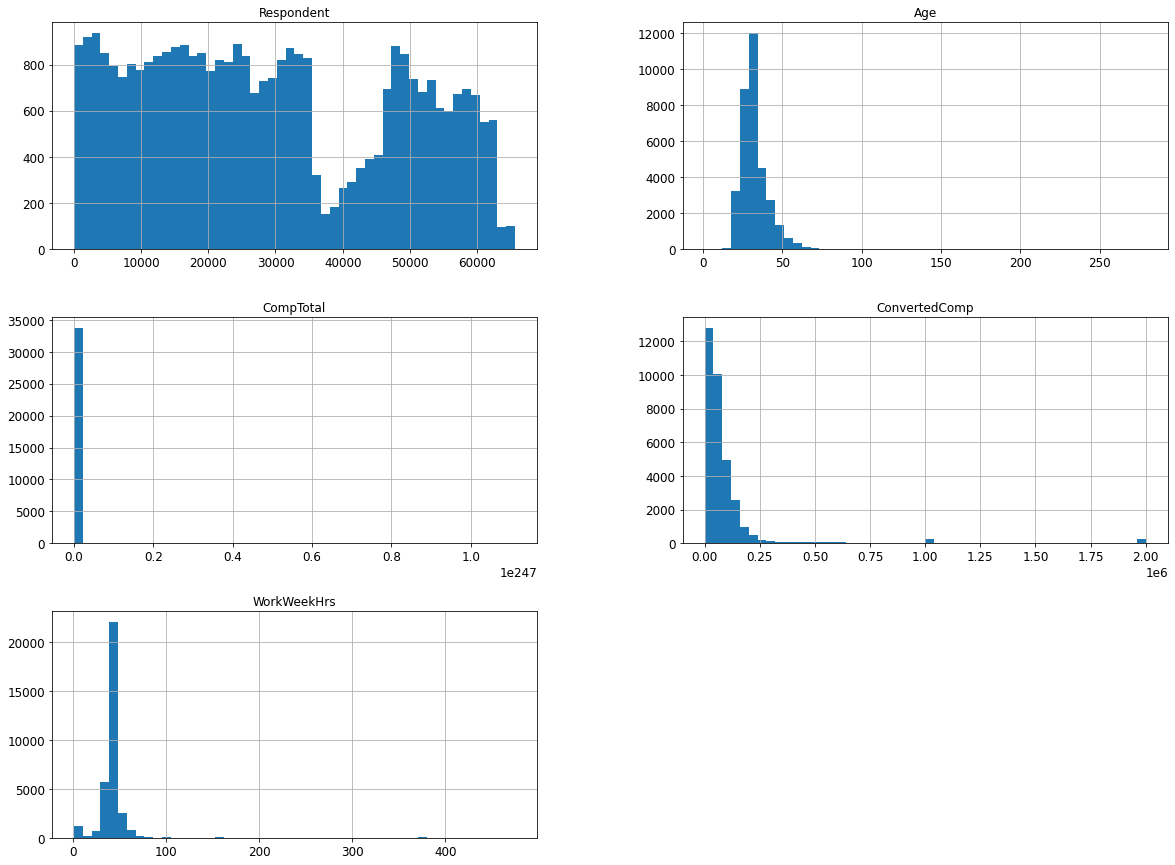

In [19]:
# Remove extreme values for Age and WorkWeekHrs
preprocess.drop(preprocess.loc[preprocess['Age']==279].index, inplace=True)
preprocess.drop(preprocess.loc[preprocess['WorkWeekHrs']>(24*7)].index, inplace=True)

# Check for distribution again 
num_cols.hist(bins=50,figsize=(20,15))
plt.show()

In [20]:
# Find the MODE value for these features: 'Age1stCode', 'YearsCode', 'YearsCodePro'
preprocess['Age1stCode'].value_counts()
preprocess['YearsCode'].value_counts()
preprocess['YearsCodePro'].value_counts()

3                     3476
2                     3378
5                     2923
4                     2696
6                     2106
10                    1987
1                     1875
8                     1707
7                     1695
less than 1 year      1381
15                    1100
12                    1095
20                    1011
9                      946
11                     759
13                     691
14                     573
16                     478
25                     397
18                     383
17                     343
22                     326
19                     283
21                     276
30                     249
23                     239
24                     182
26                     135
notmentioned           126
27                     107
35                     102
28                      92
32                      68
33                      64
34                      60
31                      59
40                      58
2

<hr>
<b><i>YearsCode</i></b> and <b><i>YearsCodePro</b></i> are 2 columns that cotain some unique value. We decide to convert <i>'less than 1 year'</i> and <i>'more than 50 years'</i> categories to numberic <i>0.5</i> and <i>51</i>. Then we replace NA value, which is <i>'notmentioned'</i> with MODE value that we calculated above for each columns. After that, we should convert all data type of 2 categories to float.
<br><br>
<b><i>Age1stCode</i></b> is also having the same kind of problem, so we repeat the same thing.
<hr>

In [21]:
# Replace highest/lowest values with the corresponding float value
# Replace 'notmentioned' values with the MODE value
preprocess['Age1stCode'] = preprocess['Age1stCode'].replace("younger than 5 years", "4")
preprocess['Age1stCode'] = preprocess['Age1stCode'].replace("older than 85", "86")
preprocess['Age1stCode'] = preprocess['Age1stCode'].replace("notmentioned", "14")

preprocess['YearsCode'] = preprocess['YearsCode'].replace("less than 1 year", "0.5")
preprocess['YearsCode'] = preprocess['YearsCode'].replace("more than 50 years", "51")
preprocess['YearsCode'] = preprocess['YearsCode'].replace("notmentioned", "10")

preprocess['YearsCodePro'] = preprocess['YearsCodePro'].replace("less than 1 year", "0.5")
preprocess['YearsCodePro'] = preprocess['YearsCodePro'].replace("more than 50 years", "51")
preprocess['YearsCodePro'] = preprocess['YearsCodePro'].replace("notmentioned", "3")

In [22]:
# Cast 'Age1stCode', 'YearsCode', 'YearsCodePro' to float type
for col in ['Age1stCode', 'YearsCode', 'YearsCodePro']:
    preprocess[col] = preprocess[col].astype('float64')

#### Handle impossible values and outliers
- The Age of Coding The First Time should not be greater than the Age
- Years of Coding Professionally should not be greater than Years of Coding
- We will drop rows that contain these impossible values

In [23]:
preprocess.drop(preprocess[preprocess['Age1stCode'] > preprocess['Age']].index, inplace = True)
preprocess.drop(preprocess[preprocess['YearsCodePro'] > preprocess['YearsCode']].index, inplace = True)

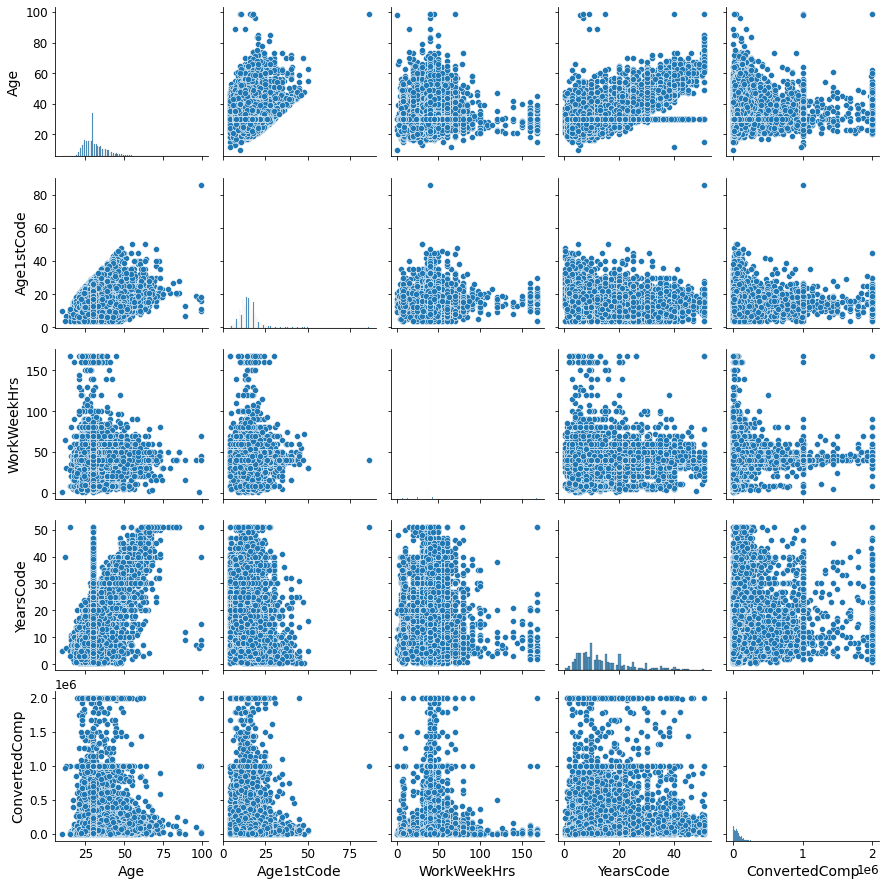

In [24]:
cols = ['Age', 'Age1stCode', 'WorkWeekHrs', 'YearsCode', 'ConvertedComp']
sns.pairplot(preprocess[cols], height = 2.5, kind='scatter', diag_kind='hist')

As could be seen from the scatter plot, there seems to be some outliers of 'Age' and 'Age1stCode' feature
I will drop instances with Age > 80 and Age1stCode > 75

In [25]:
outliers_df = preprocess.loc[(preprocess['Age'] > 80) | (preprocess['Age1stCode'] > 75)]
preprocess.drop(outliers_df.index, inplace = True)

For those instances with YearsCode > Age, we will calculate new age = YearsCode + Age1stCode, and use this new age to replace with the impossible Age value

In [26]:
preprocess[preprocess['YearsCode'] > preprocess['Age']]
preprocess.loc[preprocess['YearsCode'] > preprocess['Age'], ['Age']] = preprocess['YearsCode'] + preprocess['Age1stCode']

In [27]:
# Generate copy of ConvertedComp column
preprocess["ConvertedComp_Copy"] = preprocess["ConvertedComp"]

<AxesSubplot:>

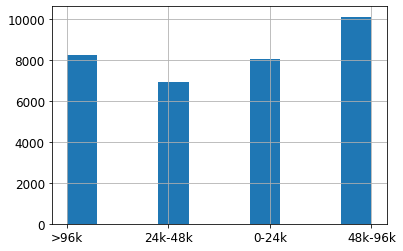

In [28]:
# Create categories for compensation
preprocess["ConvertedComp"] = pd.cut(preprocess["ConvertedComp"],
                               bins=[0, 24000, 48000, 96000, np.inf],
                               labels=['0-24k', '24k-48k', '48k-96k', '>96k'],
                               include_lowest=True)
preprocess['ConvertedComp'].hist()

In [29]:
preprocess.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33398 entries, 7 to 64153
Data columns (total 62 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Respondent                    33398 non-null  int64   
 1   MainBranch                    33398 non-null  object  
 2   Hobbyist                      33398 non-null  object  
 3   Age                           33398 non-null  float64 
 4   Age1stCode                    33398 non-null  float64 
 5   CompFreq                      33398 non-null  object  
 6   CompTotal                     33398 non-null  float64 
 7   ConvertedComp                 33398 non-null  category
 8   Country                       33398 non-null  object  
 9   CurrencyDesc                  33398 non-null  object  
 10  CurrencySymbol                33398 non-null  object  
 11  DatabaseDesireNextYear        33398 non-null  object  
 12  DatabaseWorkedWith            33398 non-null  

## Task 1.2 Data Exploration

### Exploring individual columns

**Column 1: `Age`**

Text(0.5, 0, 'Age (years)')

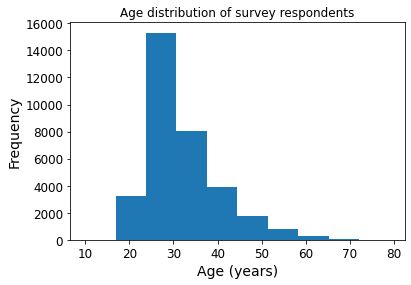

In [30]:
preprocess['Age'].plot(kind='hist')
plt.title('Age distribution of survey respondents')
plt.xlabel('Age (years)')

**Column 2: `Employment`**

Text(0, 0.5, 'Employment')

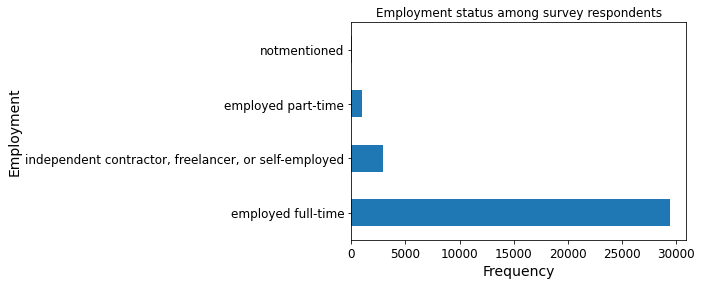

In [31]:
preprocess['Employment'].value_counts().plot(kind='barh')
plt.title('Employment status among survey respondents')
plt.xlabel('Frequency')
plt.ylabel('Employment')

**Column 3: `UndergradMajor`**

Text(0, 0.5, 'Major')

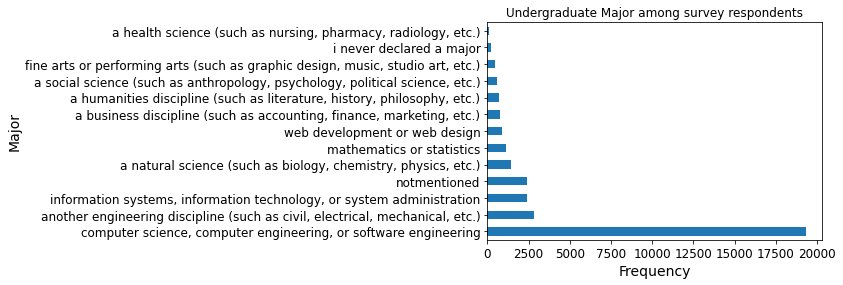

In [32]:
preprocess['UndergradMajor'].value_counts().plot(kind='barh')
plt.title('Undergraduate Major among survey respondents')
plt.xlabel('Frequency')
plt.ylabel('Major')

### Exploring relationships between columns/attributes

**Pair 1: `JobFactors` and `Gender`**

**Pair 2: `DevType` and `ConvertedComp`**

**Pair 3: `WorkWeekHrs` and `JobSat`**

## Task 2 Data Modeling


### XGBoost Preprocessing and Modeling

### CatBoost Preprocessing and Modelling

In [33]:
df_train = pd.DataFrame(data=preprocess, columns=['Respondent', 'MainBranch', 'Age', 'Hobbyist', 'CompFreq', 'Country',
                                                  'Employment', 'ConvertedComp', 'DevType', 'EdLevel', 'JobSat', 'WorkWeekHrs', 'OpSys',
                                                  'YearsCodePro', 'YearsCode'])
df_train['Age'] = df_train['Age'].astype('int')
# df_train.loc[df_train['Age'] < 16, 'Age'] = 16
# df_train.loc[df_train['Age'] > 83, 'Age'] = 83

In [34]:
df_train['DevType'] = df_train['DevType'].str.split(';')
df_train = df_train.explode('DevType')
df_train = df_train.reset_index(drop=True)

In [35]:
right_df = pd.DataFrame(data=preprocess, columns=['Respondent', 'MainBranch',
                                                  'Hobbyist', 'CompFreq', 'Country', 'JobSat', 'Age', 'Employment', 'EdLevel', 'ConvertedComp',
                                                  'WorkWeekHrs', 'OpSys', 'YearsCodePro', 'YearsCode'])
left_df = pd.crosstab(df_train['Respondent'], df_train['DevType']).rename_axis(
    None, axis=1).add_prefix('DevType_').reset_index()
df_train_new = pd.merge(right_df, left_df, on="Respondent")

In [36]:
df_train_new['WorkWeekHrs'] = df_train_new['WorkWeekHrs'].astype('int')
# df_train_new['YearsCodePro'] = df_train_new['YearsCodePro'].astype('category')
# df_train_new['YearsCode'] = df_train_new['YearsCode'].astype('category')
df_train_new['OpSys'] = df_train_new['OpSys'].astype('category')
df_train_new['Employment'] = df_train_new['Employment'].astype('category')
df_train_new['Country'] = df_train_new['Country'].astype('category')
df_train_new['CompFreq'] = df_train_new['CompFreq'].astype('category')
df_train_new['Hobbyist'] = df_train_new['Hobbyist'].astype('category')
df_train_new['MainBranch'] = df_train_new['MainBranch'].astype('category')
df_train_new['EdLevel'] = df_train_new['EdLevel'].astype('category')
df_train_new['JobSat'] = df_train_new['JobSat'].astype('category')

In [37]:
df_train_new = df_train_new.drop(['Respondent'], axis=1)

y = df_train_new['ConvertedComp']
train_data = df_train_new.drop(['ConvertedComp'], axis=1)

cat_features = np.where(train_data.dtypes == 'category')[0]

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    train_data, y, test_size=0.2, random_state=42)

# X_test.to_csv('X_test.csv', index=False)
# y_test.to_csv('y_test.csv', index=False)

train_pool = Pool(X_train, y_train, cat_features)


catboost_model = CatBoostClassifier(iterations=250,
                                    learning_rate=0.7,
                                    depth=6,
                                    random_seed=42,
                                    loss_function='MultiClass')

# # Fit CatBoost model
catboost_model.fit(train_pool)

0:	learn: 0.9515528	total: 243ms	remaining: 1m
1:	learn: 0.8744989	total: 360ms	remaining: 44.7s
2:	learn: 0.8364872	total: 495ms	remaining: 40.7s
3:	learn: 0.8195493	total: 639ms	remaining: 39.3s
4:	learn: 0.8057533	total: 761ms	remaining: 37.3s
5:	learn: 0.7949412	total: 896ms	remaining: 36.4s
6:	learn: 0.7858860	total: 1.03s	remaining: 35.9s
7:	learn: 0.7757044	total: 1.18s	remaining: 35.6s
8:	learn: 0.7681843	total: 1.3s	remaining: 34.9s
9:	learn: 0.7637408	total: 1.46s	remaining: 35s
10:	learn: 0.7586892	total: 1.61s	remaining: 34.9s
11:	learn: 0.7536306	total: 1.74s	remaining: 34.5s
12:	learn: 0.7519800	total: 1.86s	remaining: 33.9s
13:	learn: 0.7506931	total: 1.99s	remaining: 33.6s
14:	learn: 0.7468919	total: 2.14s	remaining: 33.6s
15:	learn: 0.7419050	total: 2.28s	remaining: 33.3s
16:	learn: 0.7388332	total: 2.42s	remaining: 33.2s
17:	learn: 0.7320179	total: 2.55s	remaining: 32.9s
18:	learn: 0.7296235	total: 2.68s	remaining: 32.5s
19:	learn: 0.7278441	total: 2.82s	remaining: 32

In [39]:
y_pred = catboost_model.predict(X_test)

print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

Accuracy: 0.6827844311377246


### LightGBM Preprocessing and Modelling

In [40]:
#backup dataframe
df = preprocess

<hr>
First of all, we choose columns that has enough features to train the model. By having a close look into the dataframe, we might select some important features that can be helpful such as:  <b><i>MainBranch, Country, Employment, CompFreq, OpSys, OrgSize, EdLevel, ConvertedComp, WorkWeekHrs, Age, YearsCode, YearsCodePro, NEWOvertime</b></i>. 

<b><i>NewOvertime</i></b> data column can be encode by adding new number categories <i>'0', '1', '2', '3', '4'</i> and start to replace in turn order with old categories, as the lowest number represents the lowest frequency <i>'never'</i> and the highest represents high frequence <i>'often'</i>.
<hr>

In [41]:
#drop non-meaning value
df = df[df.NEWOvertime != 'notmentioned']
#Convert columns to categories
df['NEWOvertime'] = df['NEWOvertime'].astype('category')
#Adding new categories
df['NEWOvertime'] = df['NEWOvertime'].cat.add_categories('0')
df['NEWOvertime'] = df['NEWOvertime'].cat.add_categories('1')
df['NEWOvertime'] = df['NEWOvertime'].cat.add_categories('2')
df['NEWOvertime'] = df['NEWOvertime'].cat.add_categories('3')
df['NEWOvertime'] = df['NEWOvertime'].cat.add_categories('4')
#Classifying the suitable entries
df.loc[(df['NEWOvertime'].isin(["never"])),['NEWOvertime']] = "0"
df.loc[(df['NEWOvertime'].isin(["rarely: 1-2 days per year or less"])),['NEWOvertime']] = "1"
df.loc[(df['NEWOvertime'].isin(["occasionally: 1-2 days per quarter but less than monthly"])),['NEWOvertime']] = "2"
df.loc[(df['NEWOvertime'].isin(["sometimes: 1-2 days per month but less than weekly"])),['NEWOvertime']] = "3"
df.loc[(df['NEWOvertime'].isin(["often: 1-2 days per week or more"])),['NEWOvertime']] = "4"
#Converting the columns' datatypes to numeric 
df["NEWOvertime"] = pd.to_numeric(df["NEWOvertime"], errors='raise')

<hr>We see some features are in categorical type, which is not ideally to train the model. So we create a function to encode the data to numeric types, using <b>label encoding</b>
<hr>

In [42]:
# Import label encoder
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
# transform data
def label_encode(column, dataset):
    dataset[column] = label_encoder.fit_transform(dataset[column])

<hr>Now we can start encode by calling <b><i>label_encode</i></b> method.
<hr>

In [43]:
## Encode labels in columns.
LabEnArr = ['Country', 'Employment', 'CompFreq', 'OpSys', 'OrgSize', 'EdLevel', 'MainBranch']
for i in LabEnArr:
    label_encode(i, df)

<hr>
<b><i>DevType</i></b> is also a very good feature since it can help to predict which type of developer might affect the salary the most. But before using this feature, we need to pre-process the data since it is currently very hard to train with the value.

In this case, we will divide it into each type of developer that we need, then mark it as <b><i>True</i></b> if the data contain the value. Then we set all other values as <b><i>False</i></b>. Because there are a lot of type as a <b>developer</b>: back-end, front-end, full-stack, etc., therefore we will just simply keep it as one type instead of splitting it.<hr>

In [44]:
#method to check if the user have specific role that we want
def get_DevType(type, data):
    column = 'DevType_' + type
    data['DevType_' + type]= data['DevType'].copy()
    data.loc[data[column].str.contains(type), column] = True
    data[column] = np.where(data[column].isin([True]), data[column], False)
    data[column] = data[column].astype(bool)

In [45]:
#choose which type of developer that we need
DevTypeArr = ['academic researcher', 'data or business analyst', 'data scientist or machine learning specialist', 'database administrator',
             'designer', 'developer', 'devops specialist', 'educator', 'engineer', 'engineering manager', 'marketing or sales professional', 
             'product manager', 'scientist', 'senior executive', 'system administrator']

for i in DevTypeArr:
    get_DevType(i, df)

<hr>Now we can split the dataset
<hr>

In [46]:
#copy DevType features to new dataframe
DevType_df = df.loc[:,df.columns.str.startswith('DevType_')]

In [47]:
#split X, y
X = df[['MainBranch', 'Country', 'Employment', 'CompFreq', 'OpSys', 'OrgSize', 'EdLevel', 'WorkWeekHrs',
             'Age', 'YearsCode', 'YearsCodePro', 'NEWOvertime']]
y = df['ConvertedComp']

#merge devtype features with remaining data
X = pd.concat([X, DevType_df], axis=1)

In [48]:
#KFold cross-validation
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, random_state=42, shuffle=True)

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

We are ready to train and predict the data.

In [49]:
# Parameter Tuning
para_tuning = {'boosting_type': 'gbdt', 'colsample_bytree': 1.0,
               'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
               'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
               'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31,
               'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True,
               'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 

In [50]:
# build the lightgbm model
import lightgbm as lgb

clf = lgb.LGBMClassifier(**para_tuning)
clf = clf.fit(X_train, y_train)

# predict the results
y_pred=clf.predict(X_test)

C:\Users\datb9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


In [51]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print('\n{}'.format(classification_report(y_test, y_pred)))

cm = confusion_matrix(y_test, y_pred)
print('\nConfusion Matrix\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

accuracy=accuracy_score(y_pred, y_test)
print('\nLightGBM Model accuracy score: {}'.format(accuracy_score(y_test, y_pred)))


              precision    recall  f1-score   support

       0-24k       0.79      0.84      0.82      1628
     24k-48k       0.58      0.51      0.54      1381
     48k-96k       0.63      0.68      0.65      1945
        >96k       0.76      0.72      0.74      1703

    accuracy                           0.69      6657
   macro avg       0.69      0.69      0.69      6657
weighted avg       0.69      0.69      0.69      6657


Confusion Matrix
 [[1372  184   55   17]
 [ 266  699  367   49]
 [  48  253 1319  325]
 [  46   71  367 1219]]

True Positives(TP) =  1372

True Negatives(TN) =  699

False Positives(FP) =  184

False Negatives(FN) =  266

LightGBM Model accuracy score: 0.6923539131741024


<h4><b>Check for Overfitting</b></h4>

In [52]:
# print the scores on training and test set
print('Training set score: {:.4f}'.format(clf.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(clf.score(X_test, y_test)))

Training set score: 0.7553
Test set score: 0.6924


The training and test set accuracy are quite comparable. So, we cannot say there is overfitting. 

### Model Selection

Let's have a look at all three models and compare them to each other. The one that have the highest accuracy is ....
<br><br>
Furthermore, ................
<br><br>
Therefore, we decide to save ... model for the <b>Deployment & Automation</b> and any future investigation.

In [53]:
# save the model to disk
import pickle
filename = 'pickle_model.pkl'
pickle.dump(clf, open(filename, 'wb'))

## Task 3 Model deployment & automation

This part can be achieved by running <b><i>app.py</i></b> file.

## Task 4 Visualisation dashboard